In [18]:
import numpy as np
import rasterio

combined_file_path = "../datasets/output.tif"
with rasterio.open(combined_file_path) as src:
    print(src.meta)
    width = src.meta['width']
    height = src.meta['height']
    channels = src.meta['count']
    # 分块保存ndarray，每块大小为 256 * 256
    block_size = 256
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = src.read(window=(
                (i, min(i + block_size, height)),
                (j, min(j + block_size, width)))
            )
            
            if block.shape[1:] != (block_size, block_size):
                pad_height = block_size - block.shape[1]
                pad_width = block_size - block.shape[2]
                block = np.pad(block, ((0, 0), (0, pad_height), (0, pad_width)), mode='constant')
            
            # 保存 block 数组
            np.save(f'../dataV2/train/blocks/block_{i}_{j}.npy', block)
    # data = src.read()
    # 保存 data 数组
    # np.save('data.npy', data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 43641, 'height': 39291, 'count': 5, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]'), 'transform': Affine(0.0651, 0.0, 258121.02701859066,
       0.0, -0.0651, 4518292.6701675765)}


In [19]:
from tif2pngs import Tif2Pngs, ROOT
import os


mask_file_path = os.path.join(ROOT, 'datasets', 'standard.tif')
tif2pngs = Tif2Pngs(mask_file_path, os.path.join(ROOT, 'dataV2', 'train', 'masks'))
tif2pngs.process_tif()

100%|██████████| 26334/26334 [00:20<00:00, 1270.77it/s]


In [20]:
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from shutil import copyfile

random.seed(3407)

def split_train_val(val_ratio=0.2, image_prefix='block', mask_prefix='standard', image_suffix='.npy', mask_suffix='.png'):
    source_dir = os.path.join(ROOT, 'dataV2', 'train')
    target_dir = os.path.join(ROOT, 'dataV2', 'val')

    files = os.listdir(os.path.join(source_dir, 'blocks'))

    num_files = len(files)
    num_val_files = int(num_files * val_ratio)
    val_files = random.sample(files, num_val_files)
    # 将抽取的文件复制到目标目录
    for file in tqdm(val_files):
        # 复制图像文件
        copyfile(os.path.join(source_dir, 'blocks', file), os.path.join(target_dir, 'blocks', file))
        # 复制掩码文件
        copyfile(os.path.join(source_dir, 'masks', file.replace(image_prefix, mask_prefix)).replace(image_suffix, mask_suffix),
                 os.path.join(target_dir, 'masks', file.replace(image_prefix, mask_prefix)).replace(image_suffix, mask_suffix))
        # 删除源目录下的文件
        os.remove(os.path.join(source_dir, 'blocks', file))
        os.remove(os.path.join(source_dir, 'masks', file.replace(image_prefix, mask_prefix).replace(image_suffix, mask_suffix)))
        
split_train_val(0.2)

100%|██████████| 5266/5266 [00:35<00:00, 149.90it/s]


In [4]:
import os
import numpy as np
from tqdm import tqdm
from albumentations import Compose, HorizontalFlip, VerticalFlip, ShiftScaleRotate, RandomResizedCrop, OneOf, MotionBlur, MedianBlur, Blur
from albumentations.pytorch import ToTensorV2
from PIL import Image
from tif2pngs import ROOT

# 数据增强方法
transform = Compose([
    HorizontalFlip(p=0.5),  # 随机水平翻转
    VerticalFlip(p=0.5),  # 随机垂直翻转
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=0.5),  # 随机仿射变换
    RandomResizedCrop(height=256, width=256, scale=(0.6, 1.0), p=0.5),  # 随机裁剪和调整大小
    # OneOf([
    #     MotionBlur(p=0.2),
    #     MedianBlur(blur_limit=3, p=0.1),
    #     Blur(blur_limit=3, p=0.1),
    # ], p=0.5),
    ToTensorV2()
])

# 数据增强函数
def augment_npy_images(image_path, mask_path, save_dir, transform):
    # 加载 .npy 格式的图像和 .png 格式的掩码
    image = np.load(image_path)  # 加载 block 数据，形状 (C, H, W)
    image = np.moveaxis(image, 0, -1)  # 转换为 (H, W, C)
    mask = np.array(Image.open(mask_path))  # 掩码保持单通道格式

    # 筛选掩码：仅处理包含两种及以上类别的掩码
    unique_classes = np.unique(mask)
    if len(unique_classes) < 2:
        return

    # 应用数据增强
    augmented = transform(image=image, mask=mask)
    transformed_image = augmented['image']  # 增强后的图像
    transformed_mask = augmented['mask']    # 增强后的掩码

    # 保存增强后的图像和掩码
    save_image_path = os.path.join(save_dir, 'blocks', os.path.basename(image_path).replace('.npy', '_aug.npy'))
    save_mask_path = os.path.join(save_dir, 'masks', os.path.basename(mask_path).replace('.png', '_aug.png'))

    # 保存图像为 .npy 格式
    np.save(save_image_path, transformed_image.numpy())
    # 保存掩码为 .png 格式
    Image.fromarray(transformed_mask.numpy()).save(save_mask_path)

# 数据增强目录和逻辑
def augment_dataset(source_dir, target_dir, transform):
    os.makedirs(os.path.join(target_dir, 'blocks'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'masks'), exist_ok=True)

    image_files = os.listdir(os.path.join(source_dir, 'blocks'))
    for image_file in tqdm(image_files, desc="Augmenting dataset"):
        image_path = os.path.join(source_dir, 'blocks', image_file)
        mask_path = os.path.join(source_dir, 'masks', image_file.replace('block', 'standard').replace('.npy', '.png'))

        # 增强数据并保存到目标目录
        augment_npy_images(image_path, mask_path, target_dir, transform)

# 调用增强函数
train_source_dir = os.path.join(ROOT, 'dataV2', 'train')
train_target_dir = os.path.join(ROOT, 'dataV2', 'train_aug')

augment_dataset(train_source_dir, train_target_dir, transform)
print("数据增强完成")


Augmenting dataset: 100%|██████████| 21068/21068 [03:52<00:00, 90.65it/s] 

数据增强完成


In [5]:
import torch
from PIL import Image
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(3407)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(3407)

class SegmentationDatasetV2(Dataset):
    def __init__(self,
                 root_dir,
                 transform=None,
                 array_prefix='block',
                 mask_prefix='standard',
                 array_suffix='.npy',
                 mask_suffix='.png',
                 inference=False,
                 ):
        self.root_dir = root_dir
        self.transform = transform
        self.array_prefix = array_prefix
        self.mask_prefix = mask_prefix
        self.array_suffix = array_suffix
        self.mask_suffix = mask_suffix
        self.arrays = os.listdir(os.path.join(root_dir, 'blocks'))
        self.inference = inference
        
    def __len__(self):
        return len(self.arrays)
    
    def __getitem__(self, idx):
        array_name = self.arrays[idx]
        array_path = os.path.join(self.root_dir, 'blocks', array_name)
        array = np.load(array_path)
            
        if self.inference:
            return array, array_name
        
        mask_path = os.path.join(self.root_dir, 'masks', array_name.replace(self.array_prefix, self.mask_prefix).replace(self.array_suffix, self.mask_suffix))
        mask = Image.open(mask_path)
        mask = np.array(mask)
        
        # 创建三个二进制掩码，每个类别一个
        mask_0 = (mask == 0).astype(np.uint8)  # 类别0的掩码
        mask_1 = (mask == 127).astype(np.uint8)  # 类别1的掩码
        mask_2 = (mask == 254).astype(np.uint8)  # 类别2的掩码

        # 将三个掩码堆叠成一个新的数组，形状为(3, 256, 256)
        mask = np.stack([mask_0, mask_1, mask_2], axis=0)

        # 将numpy数组转换为torch tensor
        mask = torch.tensor(mask, dtype=torch.float32)

        return array, mask


In [9]:
import os
from SegmentationDataset import ROOT
from torch.utils.data import DataLoader
from torchvision import transforms as T
import torch
import random

torch.manual_seed(3407)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(3407)
random.seed(3407)

# 阶段二，加载数据集
train_dir = os.path.join(ROOT, 'dataV2', 'train')
val_dir = os.path.join(ROOT, 'dataV2', 'val')

# 定义变换
transform = T.Compose([
    T.ToTensor(),
])

# 创建数据集
train_dataset = SegmentationDatasetV2(root_dir=train_dir)
val_dataset = SegmentationDatasetV2(root_dir=val_dir)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [10]:
len(train_dataset), len(val_dataset)

(25812, 5266)

In [11]:
array, mask = train_dataset[0]
print(array.shape, mask.shape)

(5, 256, 256) torch.Size([3, 256, 256])


In [12]:
from loss import FocalLoss
import torch
from segmentation_models_pytorch import Unet

# 检查CUDA是否可用
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 创建模型
model = Unet(encoder_name='resnet34',
             encoder_weights='imagenet',
             in_channels=5,
             classes=3,
             activation='softmax'
             ).to(device)

# 损失函数和优化器
loss_fn = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 初始化最小loss为正无穷大
min_loss = float('inf')

# TODO 训练轮次改这里
epoch_num = 50

# 训练模型
for epoch in range(1, epoch_num + 1):
    model.train()
    for batch in train_loader:
        images, masks = batch
        # 将数据和模型都移动到GPU
        images = images.to(device)
        masks = masks.to(device)
        
        # 现在masks是一个一维的tensor，每个元素对应一个像素的类别索引
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # 每个epoch结束时保存模型
    torch.save(model.state_dict(), f'../model/best_model_epoch_{epoch}.pth')
    print(f'Epoch {epoch}, Loss: {loss.item()}')


E:\DataMining\corn-anomaly-detection\venv\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1, Loss: 0.09862932562828064
Epoch 2, Loss: 0.10419300943613052
Epoch 3, Loss: 0.09914632141590118
Epoch 4, Loss: 0.08746889978647232
Epoch 5, Loss: 0.09047884494066238
Epoch 6, Loss: 0.09018455445766449
Epoch 7, Loss: 0.09341727942228317
Epoch 8, Loss: 0.08628896623849869
Epoch 9, Loss: 0.09339549392461777
Epoch 10, Loss: 0.08661578595638275
Epoch 11, Loss: 0.0909825786948204
Epoch 12, Loss: 0.08753986656665802
Epoch 13, Loss: 0.0940241888165474
Epoch 14, Loss: 0.08651669323444366
Epoch 15, Loss: 0.09591061621904373
Epoch 16, Loss: 0.09200579673051834
Epoch 17, Loss: 0.08980369567871094
Epoch 18, Loss: 0.08939044177532196
Epoch 19, Loss: 0.09061091393232346
Epoch 20, Loss: 0.09006182849407196
Epoch 21, Loss: 0.08922119438648224
Epoch 22, Loss: 0.09118054807186127
Epoch 23, Loss: 0.08771377056837082
Epoch 24, Loss: 0.0945841446518898
Epoch 25, Loss: 0.09696242213249207
Epoch 26, Loss: 0.08656681329011917
Epoch 27, Loss: 0.08733705431222916
Epoch 28, Loss: 0.08957373350858688
Epoc

In [13]:
from matplotlib import pyplot as plt
import numpy as np

one_hot_vector1 = torch.tensor([1., 0., 0.]).repeat(256, 256, 1)
one_hot_vector2 = torch.tensor([0., 1., 0.]).repeat(256, 256, 1)
one_hot_vector3 = torch.tensor([0., 0., 1.]).repeat(256, 256, 1)


i = 0
while i < len(val_dataset):
    image, mask = val_dataset[i]
    mask = mask.permute(1, 2, 0)
    comparison1 = mask == one_hot_vector1
    comparison2 = mask == one_hot_vector2
    comparison3 = mask == one_hot_vector3
    judge1 = comparison1.all(dim=2).any().item()
    judge2 = comparison2.all(dim=2).any().item()
    judge3 = comparison3.all(dim=2).any().item()
    if judge1 and judge2 and judge3:
        print(f"{i} {judge1} {judge2} {judge3}")
        break
    i += 1


114 True True True


In [14]:
image.shape

(5, 256, 256)

In [15]:
# 取 image 的[:3, :, :]，即前三个通道
image = image[:3, :, :]
print(type(image))
image.shape

<class 'numpy.ndarray'>


(3, 256, 256)

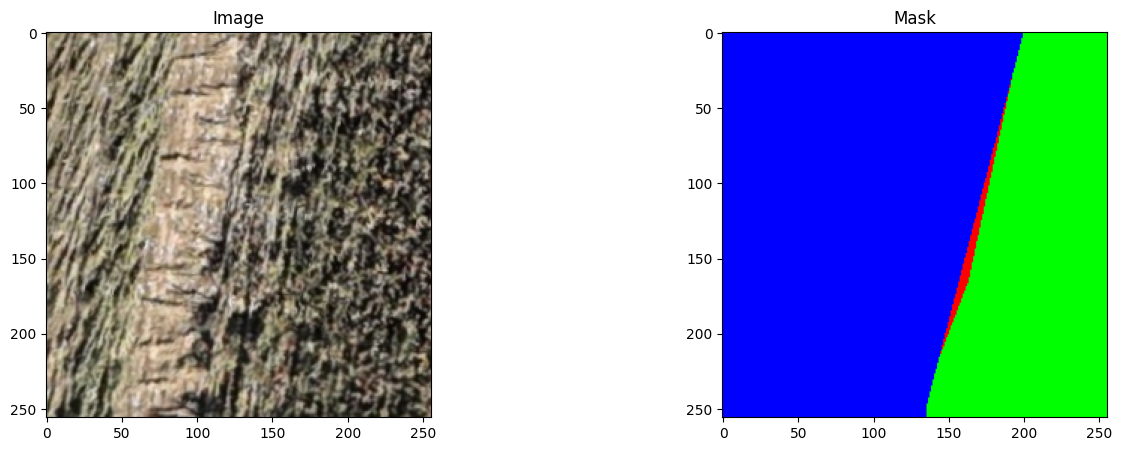

In [16]:
# 显示图像和掩码
image = np.transpose(image, (1, 2, 0)).astype(np.uint8)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask')
plt.show()

In [17]:
import torch
from segmentation_models_pytorch import Unet

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Unet(encoder_name='resnet34',
             encoder_weights='imagenet',
             in_channels=5,
             classes=3,
             activation='softmax'
             ).to(device)

model.load_state_dict(torch.load(f'../model/best_model_epoch_{50}.pth', weights_only=True))
model.eval()
pass

In [18]:
from matplotlib import pyplot as plt
import numpy as np

one_hot_vector1 = torch.tensor([1., 0., 0.]).repeat(256, 256, 1)
one_hot_vector2 = torch.tensor([0., 1., 0.]).repeat(256, 256, 1)
one_hot_vector3 = torch.tensor([0., 0., 1.]).repeat(256, 256, 1)


i = 446
while i < len(val_dataset):
    image, mask = val_dataset[i]
    mask = mask.permute(1, 2, 0)
    comparison1 = mask == one_hot_vector1
    comparison2 = mask == one_hot_vector2
    comparison3 = mask == one_hot_vector3
    judge1 = comparison1.all(dim=2).any().item()
    judge2 = comparison2.all(dim=2).any().item()
    judge3 = comparison3.all(dim=2).any().item()
    if judge1 and judge2 and judge3:
        print(f"{i} {judge1} {judge2} {judge3}")
        break
    i += 1

447 True True True


In [19]:
type(image)

numpy.ndarray

In [20]:
image_tensor = torch.tensor(image).unsqueeze(0).to(device)
image_tensor.shape

torch.Size([1, 5, 256, 256])

In [21]:
with torch.no_grad():
    # tmp = image.unsqueeze(0).to(device)
    output = model(image_tensor)
    result = (output.squeeze().cpu().numpy())
    print(result.shape)

(3, 256, 256)


E:\DataMining\corn-anomaly-detection\venv\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [22]:
result = np.where(result > 0.5, 255, 0)
result = torch.tensor(result, dtype=torch.uint8)

<class 'numpy.ndarray'>


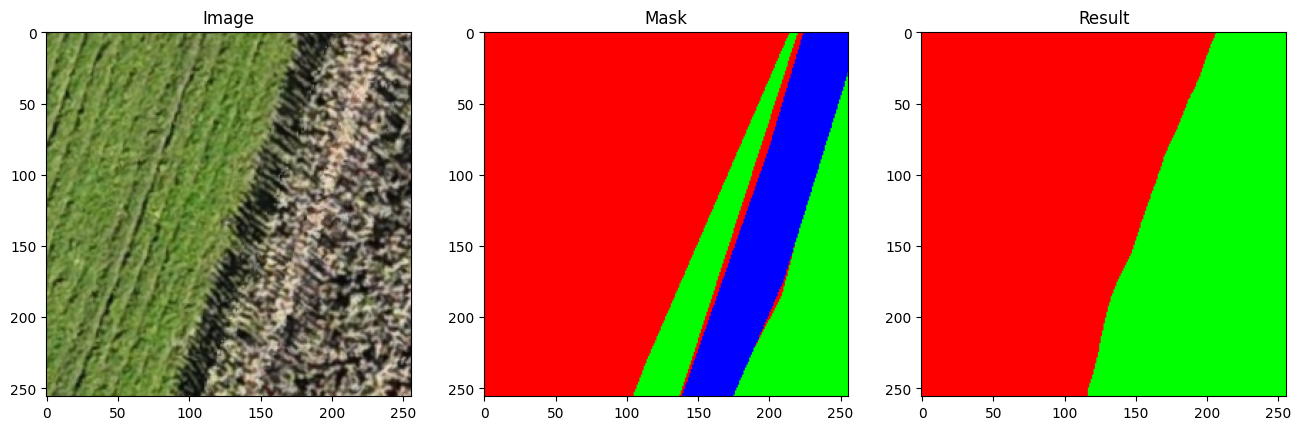

In [24]:
import matplotlib.pyplot as plt
# 取 image 的[:3, :, :]，即前三个通道
image1 = image[:3, :, :]
print(type(image))
# 显示图像和掩码
image1 = np.transpose(image1, (1, 2, 0)).astype(np.uint8)
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(image1)
plt.title('Image')
plt.subplot(1, 3, 2)
# plt.imshow(mask.permute(1, 2, 0))
plt.imshow(mask)
plt.title('Mask')
plt.subplot(1, 3, 3)
plt.imshow(result.permute(1, 2, 0))
plt.title('Result')
plt.show()


In [13]:
from eval import cal_score, cal_score_v2
score = cal_score_v2(model, val_dataset)

ValueError: expected 4D input (got 3D input)